In [103]:
import openke
from openke.config import Trainer, Tester
from openke.module.model import TransE, TransR, ComplEx, RotatE, TransH, TransD
from openke.module.loss import MarginLoss
from openke.module.strategy import NegativeSampling
from openke.data import TrainDataLoader, TestDataLoader

%matplotlib notebook 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
train_dataloader = TrainDataLoader(
     in_path = "./ccks_data/openke_format/",
     nbatches = 100,
     threads = 8,
     sampling_mode = "normal",
     bern_flag = 1,
     filter_flag = 1,
     neg_ent = 25,
     neg_rel = 0)

In [3]:
transe = TransE(
      ent_tot = train_dataloader.get_ent_tot(),
      rel_tot = train_dataloader.get_rel_tot(),
      dim = 200,
      p_norm = 1,
      norm_flag = True)

In [73]:
transr = TransR(
     ent_tot = train_dataloader.get_ent_tot(),
      rel_tot = train_dataloader.get_rel_tot(),
      dim_e = 200,
      dim_r = 200,
      p_norm = 1,
      norm_flag = True,
      rand_init = False)

transr.load_checkpoint('./checkpoint/transr.ckpt')
transr_ent = transr.ent_embeddings.weight.detach().numpy()
print(transr_ent.shape)

(7844, 200)


In [81]:
complEx = ComplEx(
     ent_tot = train_dataloader.get_ent_tot(),
     rel_tot = train_dataloader.get_rel_tot(),
     dim = 200
)
complEx.load_checkpoint('./checkpoint/complEx.ckpt')
complEx_ent1 = complEx.ent_re_embeddings.weight.detach().numpy()
complEx_ent2 = complEx.ent_im_embeddings.weight.detach().numpy()

print(complEx_ent1.shape)

(7844, 200)


In [88]:
rotate = RotatE(
      ent_tot = train_dataloader.get_ent_tot(),
      rel_tot = train_dataloader.get_rel_tot(),
      dim = 1024,
      margin = 6.0,
      epsilon = 2.0,
)
rotate.load_checkpoint('./checkpoint/rotate.ckpt')
rotate_ent = rotate.ent_embeddings.weight.detach().numpy()
print(rotate_ent.shape)

(7844, 2048)


In [105]:
transh = TransH(
      ent_tot = train_dataloader.get_ent_tot(),
      rel_tot = train_dataloader.get_rel_tot(),
      dim = 200,
      p_norm = 1,
      norm_flag = True)

transh.load_checkpoint('./checkpoint/transh.ckpt')
transh_ent = transh.ent_embeddings.weight.detach().numpy()
print(transh_ent.shape)

(7844, 200)


In [108]:
transd = TransD(
      ent_tot = train_dataloader.get_ent_tot(),
      rel_tot = train_dataloader.get_rel_tot(),
      dim_e = 200,
      dim_r = 200,
      p_norm = 1,
      norm_flag = True)

transd.load_checkpoint('./checkpoint/transd.ckpt')
transd_ent = transd.ent_embeddings.weight.detach().numpy()
print(transd_ent.shape)

(7844, 200)


In [4]:
transe.load_checkpoint('./checkpoint/transe.ckpt')

In [8]:
transe_ent = transe.ent_embeddings.weight.detach().numpy()

In [11]:
transe_ent.shape

(7844, 200)

In [12]:
transe_rel = transe.rel_embeddings.weight.detach().numpy()

In [13]:
transe_rel.shape

(4, 200)

In [19]:
import json
e2id = dict()
id2e = list()

entity2id = open("./ccks_data/openke_format/entity2id.txt").readlines()
for each in entity2id:
    e = each.strip().split("\t")
    if len(e) ==1:
        continue
    e2id[e[0]] = int(e[1])
    assert len(id2e) == int(e[1])
    id2e.append(e[0])

print(len(e2id))

7844


In [113]:
from collections import Counter
def entity_fine_grained():
    
    entity_type = json.load(open("./ccks_data/ccks_7_3_data_nolabel/entities.json"))
    e2t = list()
    print(len(entity_type["Virus"]))
    print(len(entity_type["Drug"]))
    print(len(entity_type["Protein"]))

    # 0: virus
    # 1: drug
    # 2: protein (virus protein)
    # 3:(host protein)
    for i in range(len(id2e)):
        if id2e[i] in entity_type["Virus"]:
            e2t.append(0)
        if id2e[i] in entity_type["Drug"]:
            e2t.append(1)
        if id2e[i] in entity_type["Protein"]:
            e2t.append(2)

    entity_attr = json.load(open("./ccks_data/ccks_7_3_data_nolabel/attrs.json"))
    for each in entity_attr["attrs"]:
        if each[0] in entity_type["Protein"] and each[1] == "protein_type":
            assert e2t[e2id[each[0]]] == 2
            if each[2] == "Virus Protein":
                e2t[e2id[each[0]]] = 2
            elif each[2] == "Host Protein":
                e2t[e2id[each[0]]] = 3

    return e2t

e2ft = entity_fine_grained()
print(Counter(e2ft))

240
72
7532
Counter({3: 6711, 2: 821, 0: 240, 1: 72})


In [186]:
def visualize_entity(trained_embs, kg_type):

    entity_type = json.load(open("./ccks_data/ccks_7_3_data_nolabel/entities.json"))
    e2t = list()
    print(len(entity_type["Virus"]))
    print(len(entity_type["Drug"]))
    print(len(entity_type["Protein"]))

    pro2_num = 0
    pro3_num = 0
    vectors = []

    for i in range(len(id2e)):
        if e2ft[i] < 2:
            e2t.append(e2ft[i])
            vectors.append(trained_embs[i])
        elif e2ft[i] ==2 and pro2_num < 350:
            pro2_num +=1
            e2t.append(e2ft[i])
            vectors.append(trained_embs[i])
        elif e2ft[i] ==3 and pro3_num < 350:
            pro3_num +=1
            e2t.append(e2ft[i])
            vectors.append(trained_embs[i])
         
    print(len(e2t))
    
    pca = PCA(n_components=2)
    
    vectors_ = pca.fit_transform(vectors)
    plt.figure(figsize=(5, 4))
    classes = ['Virus', 'Drug', 'Virus Protein', 'Host Protein']

    scatter = plt.scatter(vectors_[:,0],vectors_[:, 1],c=e2t)
    plt.legend(handles= scatter.legend_elements()[0],title="Types", labels=classes)

    plt.title("Entity embedding trained from " + kg_type)
    plt.show()
    
    

240
72
7532
612


<IPython.core.display.Javascript object>


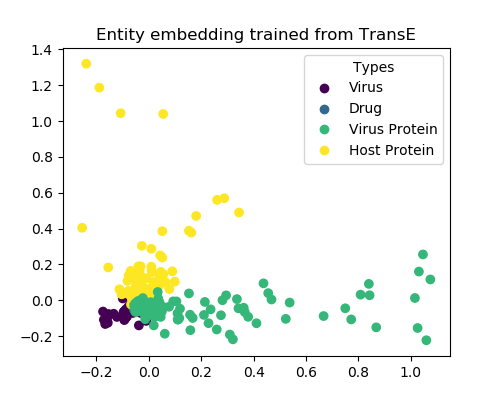

In [117]:
visualize_entity(transe_ent, "TransE")

240
72
7532
612


<IPython.core.display.Javascript object>


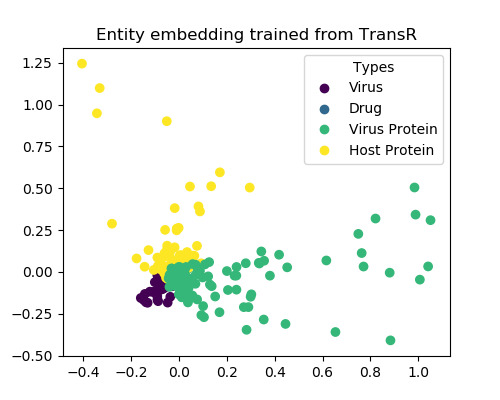

In [118]:
visualize_entity(transr_ent, "TransR")

240
72
7532
612


<IPython.core.display.Javascript object>


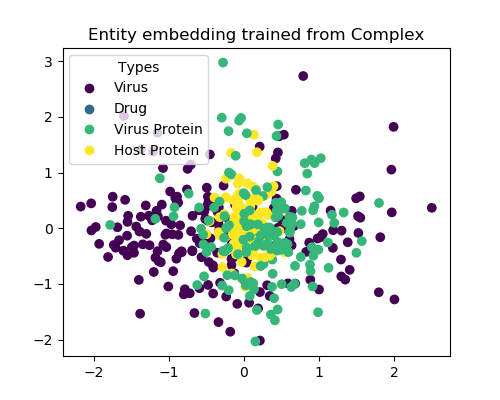

In [123]:
visualize_entity(complEx_ent1, "Complex")

240
72
7532
612


<IPython.core.display.Javascript object>


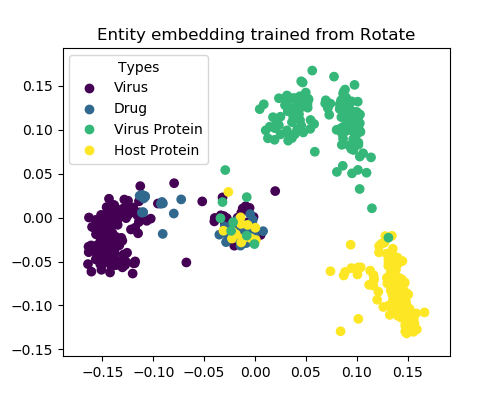

In [120]:
visualize_entity(rotate_ent, "Rotate")

240
72
7532
612


<IPython.core.display.Javascript object>


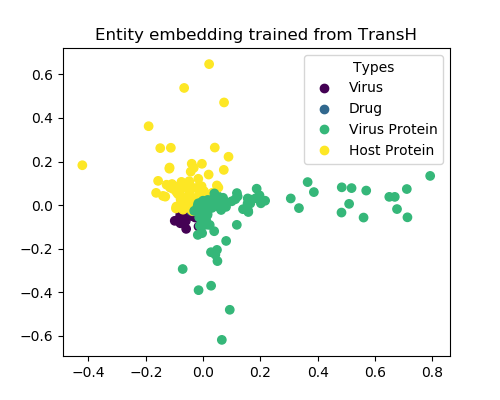

In [121]:
visualize_entity(transh_ent, "TransH")

240
72
7532
612


<IPython.core.display.Javascript object>


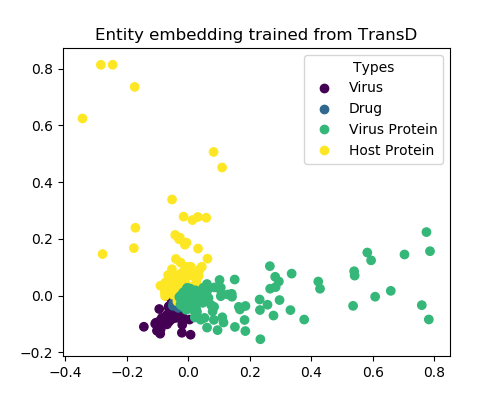

In [122]:
visualize_entity(transd_ent, "TransD")

In [155]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

def classification(train_embs, labels):
    X_train, X_test, y_train, y_test = train_test_split(train_embs , labels, test_size=0.10,random_state=42)
    clf1 = LogisticRegression(random_state=0).fit(X_train, y_train)
    clf2 = svm.SVC(kernel='linear', C=1.0).fit(X_train, y_train)
    clf3 = MLPClassifier(hidden_layer_sizes=100).fit(X_train, y_train)
    
    y_pred1 = clf1.predict(X_test)
    y_pred2 = clf2.predict(X_test)
    y_pred3 = clf3.predict(X_test)

    accuracy1 = accuracy_score(y_test, y_pred1)
    print("Accuracy (train) for LR: %0.1f%% " % (accuracy1 * 100))
    
    accuracy2 = accuracy_score(y_test, y_pred2)
    print("Accuracy (train) for SVM: %0.1f%% " % (accuracy2 * 100))
    
    accuracy3 = accuracy_score(y_test, y_pred3)
    print("Accuracy (train) for MLP: %0.1f%% " % (accuracy3 * 100))

In [152]:
classification(complEx_ent1, e2ft)

/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy (train) for LR: 89.8% 
Accuracy (train) for SVM: 90.6% 
Accuracy (train) for MLP: 95.2% 


In [156]:
classification(rotate_ent, e2ft)

/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy (train) for LR: 97.8% 
Accuracy (train) for SVM: 98.0% 
Accuracy (train) for MLP: 97.7% 


In [158]:
import networkx as nx
import numpy as np

edge_list = open("./ccks_data/openke_format/all_edges/all_edges_norel.txt").readlines()
edge_l = [each.strip() for each in edge_list]
print(len(edge_l))
KG = nx.parse_edgelist(edge_l, create_using=nx.DiGraph(), nodetype=int)
print(KG.number_of_nodes(), KG.number_of_edges())
#7844 nodes

44256
7593 44255


In [162]:
print(len([each for each in range(7844) if each not in list(KG.nodes)]))

251


In [179]:
from node2vec import Node2Vec
n2v = Node2Vec(KG, dimensions=200, walk_length=5, num_walks=10, workers=4)
model = n2v.fit(window=3, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/7593 [00:00<?, ?it/s]

In [183]:
n2v_emb = list()
for i in range(len(id2e)):
    if str(i) in model.wv:
        n2v_emb.append(model.wv.get_vector(str(i)))
    else:
        n2v_emb.append(np.random.random(200))

In [184]:
len(n2v_emb)

7844

240
72
7532
1012


<IPython.core.display.Javascript object>


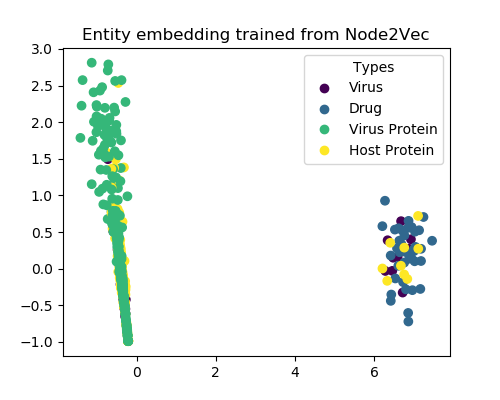

In [187]:
visualize_entity(n2v_emb, "Node2Vec")

In [188]:
classification(n2v_emb, e2ft)

/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy (train) for LR: 85.5% 
Accuracy (train) for SVM: 85.5% 
Accuracy (train) for MLP: 88.8% 
